In [3]:
!pip install pyspark

In [1]:
import pyspark

In [2]:
from pyspark import SparkContext, SparkConf

## Spark application

In [3]:
!hdfs dfsadmin -safemode leave

Safe mode is OFF


In [4]:
conf = SparkConf().set("spark.executor.instances", "2").set("spark.executor.cores", "1").set("spark.executor.memory", "1g")
#  .set("spark.sql.execution.arrow.pyspark.enabled", "true")
# conf.set('spark.yarn.dist.files','file:/usr/hdp/2.3.2.0-2950/spark/python/lib/pyspark.zip,file:/usr/hdp/2.3.2.0-2950/spark/python/lib/py4j-0.8.2.1-src.zip')
# conf.setExecutorEnv('PYTHONPATH','pyspark.zip:py4j-0.10.9.7-src.zip')

In [5]:
sc = SparkContext(appName="belyakov_spark", master="yarn")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/13 16:47:08 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [6]:
from zipfile import PyZipFile

In [11]:
ml_zip_path = "../randomBullCrab/ml-latest-small.zip"
ml_zip = PyZipFile(ml_zip_path)
ml_zip.extractall("../randomBullCrab/")

In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.functions import col

In [9]:
spark = SparkSession.builder.config(conf=conf).master(master="yarn").getOrCreate()

In [10]:
ratings_schema = StructType(fields=[
    StructField("userId", IntegerType()),
    StructField("movieId", IntegerType()),
    StructField("rating", DoubleType()),
    StructField("timestamp", LongType()),
])

In [17]:
!hdfs dfs -put ../randomBullCrab/ml-latest-small .

In [11]:
ratings_df = spark\
    .read\
    .format("csv")\
    .option("header", "True")\
    .schema(ratings_schema)\
    .load("ml-latest-small/ratings.csv")

In [12]:
ratings_df.count()

100836

In [13]:
tags_schema = StructType(fields=[
    StructField("userId", IntegerType()),
    StructField("movieId", IntegerType()),
    StructField("tag", StringType()),
    StructField("timestamp", LongType()),
])

In [14]:
tags_df = spark\
    .read\
    .format("csv")\
    .option("header", "True")\
    .schema(tags_schema)\
    .load("ml-latest-small/tags.csv")

In [15]:
tags_df.count()

3683

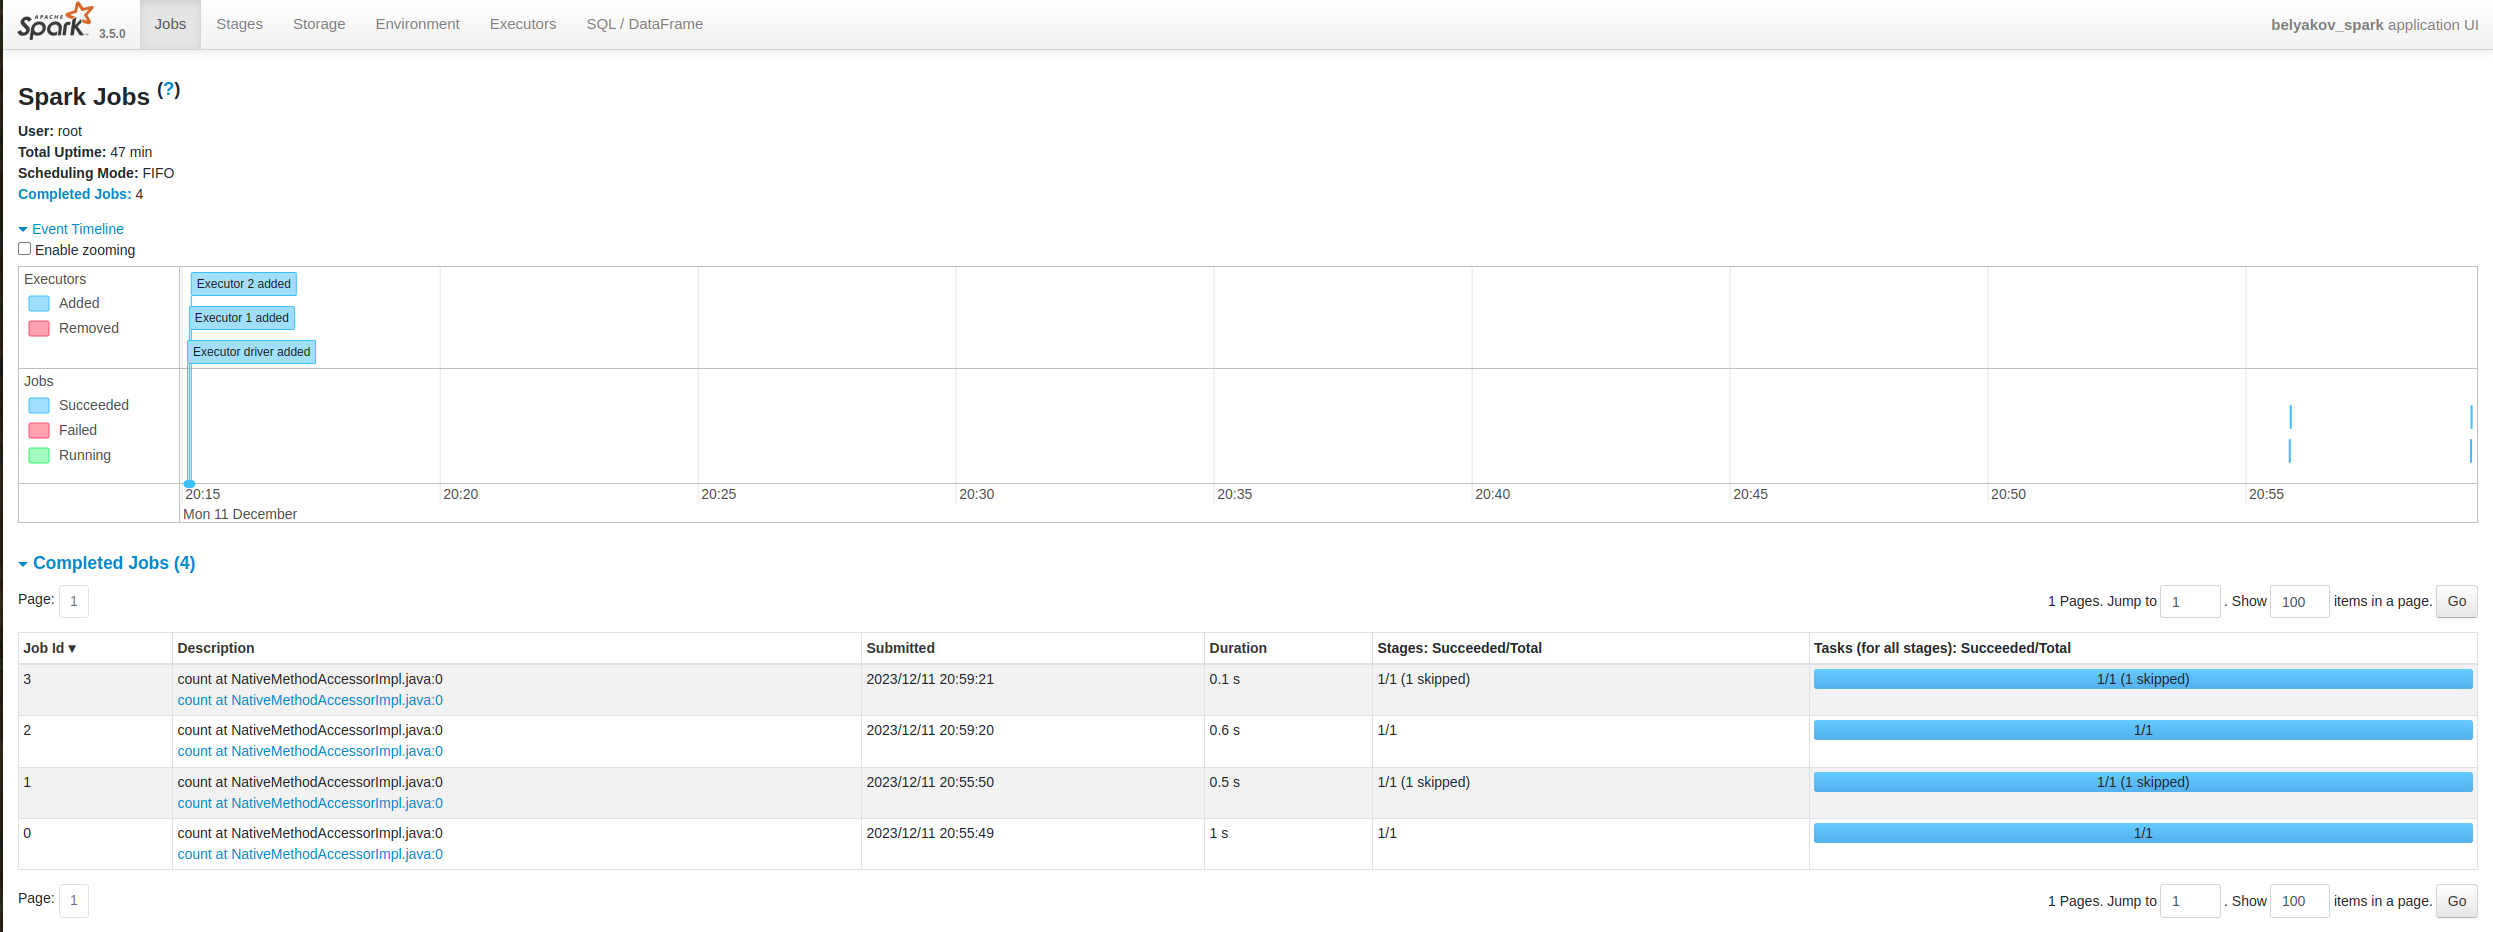

In [23]:
# остальные скрины в папке screenshots в корне

## Работа с данными

In [27]:
# Посчитать количество уникальных фильмов и уникальных юзеров в таблице “ratings”. (5 баллов)
ratings_df\
 .select("rating")\
 .distinct()\
 .count()

10

In [28]:
ratings_df\
 .select("userId")\
 .distinct()\
 .count()

610

In [36]:
# Посчитать, сколько было поставлено оценок >= 4.0. (5 баллов)
ratings_df\
 .filter(col("rating") >=4)\
 .count()

48580

In [34]:
ratings_df.count()

100836

In [43]:
# Вывести топ100 фильмов с самым высоким рейтингом. (6 баллов)
ratings_df\
 .select(col("movieId"), col("rating"))\
 .sort(col("rating").desc())\
 .limit(100)\
 .show(100)

# можно сделать select после сорта и только по муви-айди, чтобы вывести только их, но, кмк, нагляднее с рейтингом
# limit избыточен, конечно, достаточно просто show(100), но пускай будет

+-------+------+
|movieId|rating|
+-------+------+
|   1573|   5.0|
|   3147|   5.0|
|   1732|   5.0|
|   1617|   5.0|
|   3053|   5.0|
|   1625|   5.0|
|     50|   5.0|
|   1804|   5.0|
|    151|   5.0|
|   1927|   5.0|
|    163|   5.0|
|   1954|   5.0|
|    231|   5.0|
|   2005|   5.0|
|    333|   5.0|
|   2018|   5.0|
|    457|   5.0|
|   2033|   5.0|
|    553|   5.0|
|   2048|   5.0|
|    608|   5.0|
|   2058|   5.0|
|    919|   5.0|
|   2078|   5.0|
|    940|   5.0|
|   2090|   5.0|
|   1023|   5.0|
|   2094|   5.0|
|   1025|   5.0|
|   2115|   5.0|
|   1031|   5.0|
|   2116|   5.0|
|   1049|   5.0|
|   2137|   5.0|
|   1080|   5.0|
|   2139|   5.0|
|   1092|   5.0|
|   2141|   5.0|
|   1136|   5.0|
|   2161|   5.0|
|   1197|   5.0|
|   2291|   5.0|
|   1206|   5.0|
|   2329|   5.0|
|   1213|   5.0|
|   2353|   5.0|
|   1222|   5.0|
|   2387|   5.0|
|   1226|   5.0|
|   2395|   5.0|
|   1256|   5.0|
|   2427|   5.0|
|   1275|   5.0|
|   2459|   5.0|
|   1282|   5.0|
|   2470|   5.

In [51]:
# Посчитать разницу во времени в секундах между временем тегирования пользователя данного фильма и временем, 
# когда пользователь поставил оценку фильму. 
# В качестве ответа выведете среднюю дельту по времени. (7 баллов)
rating_tags_df = ratings_df\
 .withColumnRenamed("timestamp", "ratingTimestamp")\
 .join(tags_df.withColumnRenamed("timestamp", "tagTimestamp"), ["userId", "movieId"])
rating_tags_df.show()

+------+-------+------+---------------+-----------------+------------+
|userId|movieId|rating|ratingTimestamp|              tag|tagTimestamp|
+------+-------+------+---------------+-----------------+------------+
|     2|  60756|   5.0|     1445714980|     will ferrell|  1445714992|
|     2|  60756|   5.0|     1445714980|  Highly quotable|  1445714996|
|     2|  60756|   5.0|     1445714980|            funny|  1445714994|
|     2|  89774|   5.0|     1445715189|        Tom Hardy|  1445715205|
|     2|  89774|   5.0|     1445715189|              MMA|  1445715200|
|     2|  89774|   5.0|     1445715189|     Boxing story|  1445715207|
|     2| 106782|   5.0|     1445714966|  Martin Scorsese|  1445715056|
|     2| 106782|   5.0|     1445714966|Leonardo DiCaprio|  1445715051|
|     2| 106782|   5.0|     1445714966|            drugs|  1445715054|
|     7|  48516|   1.0|     1169687318|     way too long|  1169687325|
|    18|    431|   4.0|     1462138790|            mafia|  1462138755|
|    1

23/12/13 12:43:29 WARN Column: Constructing trivially true equals predicate, 'movieId#1 = movieId#1'. Perhaps you need to use aliases.


In [58]:
# так как таймстемп указан в секундах, можно просто вычесть значения, без доп конвертации 
rating_tags_df.withColumn("tagTimeDelta", col("tagTimestamp") - col("ratingTimestamp"))\
 .select(col("userId"), col("movieId"), col("tagTimeDelta"))\
 .groupBy(["userId", "movieId"])\
 .mean("tagTimeDelta")\
 .show(100)

+------+-------+------------------+
|userId|movieId| avg(tagTimeDelta)|
+------+-------+------------------+
|    62| 108190|              13.0|
|   474|    412|      1.62008122E8|
|   474|    551|      1.62708921E8|
|   474|   1348|       8.4353215E7|
|   474|   1513|       9.0488464E7|
|   474|   4027|               3.0|
|   474|   5876|       7.8380895E7|
|   474|   6380|       4.6332209E7|
|   474|  30707|       3.0255922E7|
|   125|  60950|              97.0|
|   424|   3499|15.857142857142858|
|   474|     32|       5.6029417E7|
|   474|     43|       5.6959719E7|
|   474|   1797|      -2.8338047E7|
|   474|   5644|       7.4408325E7|
|   477|  62336|       4.8071423E7|
|   119| 115149|         1200059.0|
|   318|  64034|    -2.017194685E8|
|   424|   2160|              31.6|
|   474|    671|        8.511647E7|
|   474|   1178|               8.0|
|   474|   2108|      1.63363276E8|
|   567| 112552|              11.0|
|   474|   1125|      1.58799586E8|
|   474|   1304|       8.511

In [59]:
# Посчитать среднюю оценку от каждого пользователя, 
# в качестве ответа выведете среднее от всех усредненных оценок всех пользователей. (7 баллов)

ratings_df\
 .select(col("userId"), col("rating"))\
 .groupBy("userId")\
 .mean("rating")\
 .show(100)

+------+------------------+
|userId|       avg(rating)|
+------+------------------+
|   148|3.7395833333333335|
|   463| 3.787878787878788|
|   471|             3.875|
|   496| 3.413793103448276|
|   243| 4.138888888888889|
|   392|               3.2|
|   540|               4.0|
|    31|              3.92|
|   516|3.6923076923076925|
|    85|3.7058823529411766|
|   137| 3.978723404255319|
|   251| 4.869565217391305|
|   451|3.7941176470588234|
|   580| 3.529816513761468|
|    65| 4.029411764705882|
|   458|4.1525423728813555|
|    53|               5.0|
|   255|2.5681818181818183|
|   481| 2.806451612903226|
|   588|              3.25|
|   133|               3.0|
|   296| 4.166666666666667|
|   472| 4.120689655172414|
|    78|3.1639344262295084|
|   322| 3.411214953271028|
|   513|          3.890625|
|   321|3.5714285714285716|
|   362| 4.243119266055046|
|   375| 3.909090909090909|
|   593| 3.266990291262136|
|   597|3.9774266365688487|
|   108| 3.986842105263158|
|   155| 3.608695652

## UDF

In [ ]:
"""
Обучите модель предсказания оценок по тегам с помощью TfidfVectorizer и SGDRegressor из модуля scikit-learn - 
тут уже можно сконвертировать два датасета в pandas через .toPandas
сначала  TfidfVectorizer обучаете на колонке “tag”
получаете численные признаки transform-ом от tfidf на той же колонке “tag”
обучаете SGDRegressor на новых численных признаках от  TfidfVectorizer-а с лейблом “rating”


Напишите UDF, которая делает предсказание рейтинга по столбцу “tag”
сначала transform от TfidfVectorizer
затем predict от SGDRegressor на полученных признаках из 1 этапа


Примените UDF к spar-dataframe-у и убедитесь, что udf работает (можно вызвать какой нибудь action, например show(50)). 
Приложите скрин дага вычислений этой джобы в spark-ui. (15 баллов)
"""

In [62]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 10.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 5.6 MB/s eta 0:00:00:00:0100:01


In [65]:
!pip install -U pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 8.9 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.5/502.5 KB 8.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 KB 7.8 MB/s eta 0:00:0000:01


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDRegressor

In [17]:
mean_raitings_df = ratings_df\
 .select(col("movieId"), col("rating"))\
 .groupBy("movieId")\
 .mean("rating")

train_df = tags_df\
 .select(col("movieId"), col("tag"))\
 .groupBy("movieId")\
 .agg(F.collect_list("tag"))\
 .join(mean_raitings_df, "movieId")\
 .select(col("movieId"), col("avg(rating)").alias("rating"), F.concat_ws(' ' , "collect_list(tag)").alias("tags"))

In [18]:
train_df.show()

+-------+------------------+--------------------+
|movieId|            rating|                tags|
+-------+------------------+--------------------+
|   1580| 3.487878787878788|              aliens|
|   3175|              3.58|               spoof|
|   1088| 3.369047619047619|         dance music|
|   1645| 3.411764705882353|             lawyers|
|    471|              3.55|           hula hoop|
|   1959|3.6666666666666665|     adultery Africa|
|   2122|2.4545454545454546|        Stephen King|
|   6620|3.8333333333333335|              cancer|
|   8638|               3.7|        generation X|
|   6466|               3.5|    In Netflix queue|
|   7833|               3.5|Nick and Nora Cha...|
|   1025|              3.58|  Disney King Arthur|
|   2387|            3.4375|dark comedy dark ...|
|   1084| 4.071428571428571|     1920s gangsters|
|    540|2.6666666666666665|                 bad|
|   1721| 3.414285714285714|   shipwreck romance|
|    858|         4.2890625|               Mafia|


In [19]:
train_df.toPandas().head(20)

,movieId,rating,tags
0,1580,3.487879,aliens
1,3175,3.580000,spoof
2,1088,3.369048,dance music
3,1645,3.411765,lawyers
4,471,3.550000,hula hoop
5,1959,3.666667,adultery Africa
6,2122,2.454545,Stephen King
7,6620,3.833333,cancer
8,8638,3.700000,generation X
9,6466,3.500000,In Netflix queue


In [24]:
train_df.toPandas().tags.apply(lambda x: model.predict(vectorizer.transform([x]))[0]).head(25)

0     3.530890
1     3.409542
2     3.631356
3     3.004507
4     2.629213
5     3.649872
6     3.521826
7     2.951639
8     3.143145
9     3.920654
10    3.724149
11    3.919680
12    4.332544
13    2.948409
14    3.144318
15    2.891580
16    3.746796
17    3.269711
18    2.648352
19    3.962836
20    3.317805
21    3.018293
22    3.629201
23    3.433776
24    3.312559
Name: tags, dtype: float64

In [21]:
tags_corpus = train_df.toPandas()["tags"].values
ratings = train_df.toPandas()["rating"].values

In [22]:
vectorizer = TfidfVectorizer().fit(tags_corpus)

In [23]:
model = SGDRegressor().fit(vectorizer.transform(tags_corpus), ratings)

In [78]:
# @F.udf(DoubleType())
def predict_ratings(tags, model, vectorizer):
    return float(model.predict(vectorizer.transform([tags]))[0])
predict_ratings_udf = F.udf(lambda x: predict_ratings(x, model, vectorizer), DoubleType())

In [86]:
ratings_predicted = train_df\
 .withColumn("ratings_predicted", predict_ratings_udf(col("tags")))

In [87]:
ratings_predicted.show(25)

+-------+------------------+--------------------+------------------+
|movieId|            rating|                tags| ratings_predicted|
+-------+------------------+--------------------+------------------+
|   1580| 3.487878787878788|              aliens|3.5308903019231677|
|   3175|              3.58|               spoof|3.4095418831302635|
|   1088| 3.369047619047619|         dance music|3.6313560810488124|
|   1645| 3.411764705882353|             lawyers| 3.004507388971059|
|    471|              3.55|           hula hoop|2.6292125149241543|
|   1959|3.6666666666666665|     adultery Africa| 3.649872137598865|
|   2122|2.4545454545454546|        Stephen King|3.5218261852012507|
|   6620|3.8333333333333335|              cancer|2.9516393335821878|
|   8638|               3.7|        generation X| 3.143145145658083|
|   6466|               3.5|    In Netflix queue|3.9206540871661133|
|   7833|               3.5|Nick and Nora Cha...| 3.724149468986642|
|   1025|              3.58|  Disn

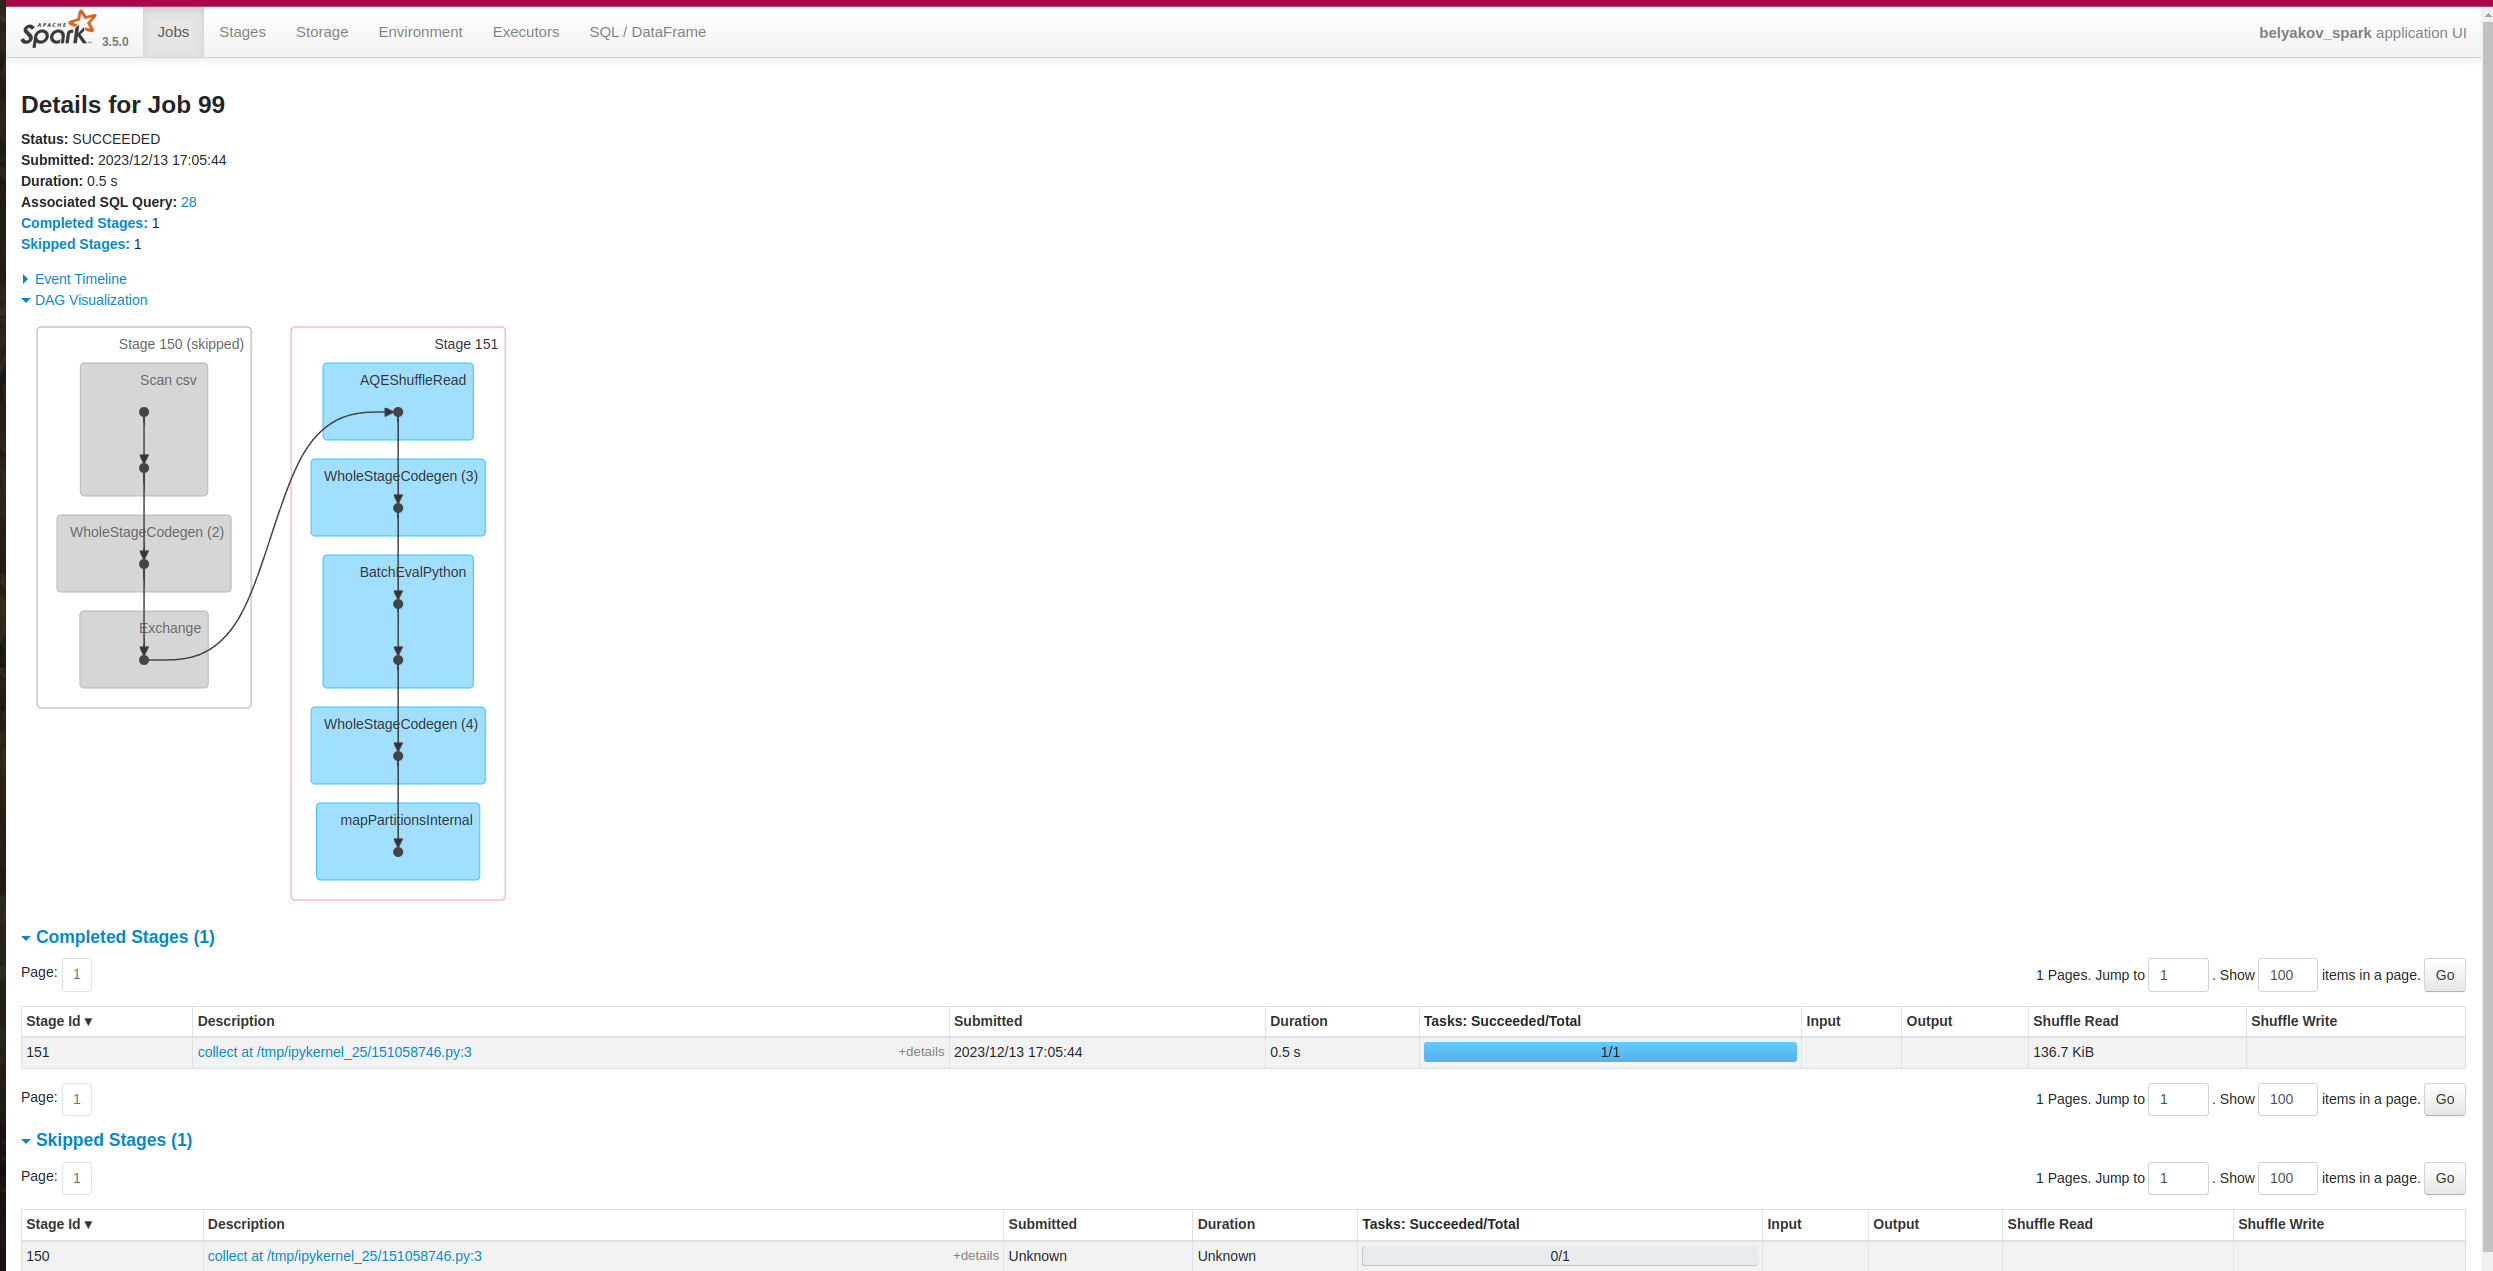

In [ ]:
# Напишите, чему равен корень суммы квадратов разностей (RMSE) между предсказанным и истинным значением рейтинга (напишите это на pyspark-е). 
# Напишите, сколько было выполнено стейджей и тасок в рамках джобы. (10 баллов)

In [92]:
rmse = ratings_predicted.withColumn("squarederror",
                           F.pow(col("rating") - col("ratings_predicted"),
                                   F.lit(2)
                           ))\
  .select(F.avg(col("squarederror")).alias("mse"))\
  .withColumn("rmse", F.sqrt(F.col("mse")))

In [94]:
rmse.show()

+-------------------+------------------+
|                mse|              rmse|
+-------------------+------------------+
|0.47524581233820157|0.6893807455522685|
+-------------------+------------------+



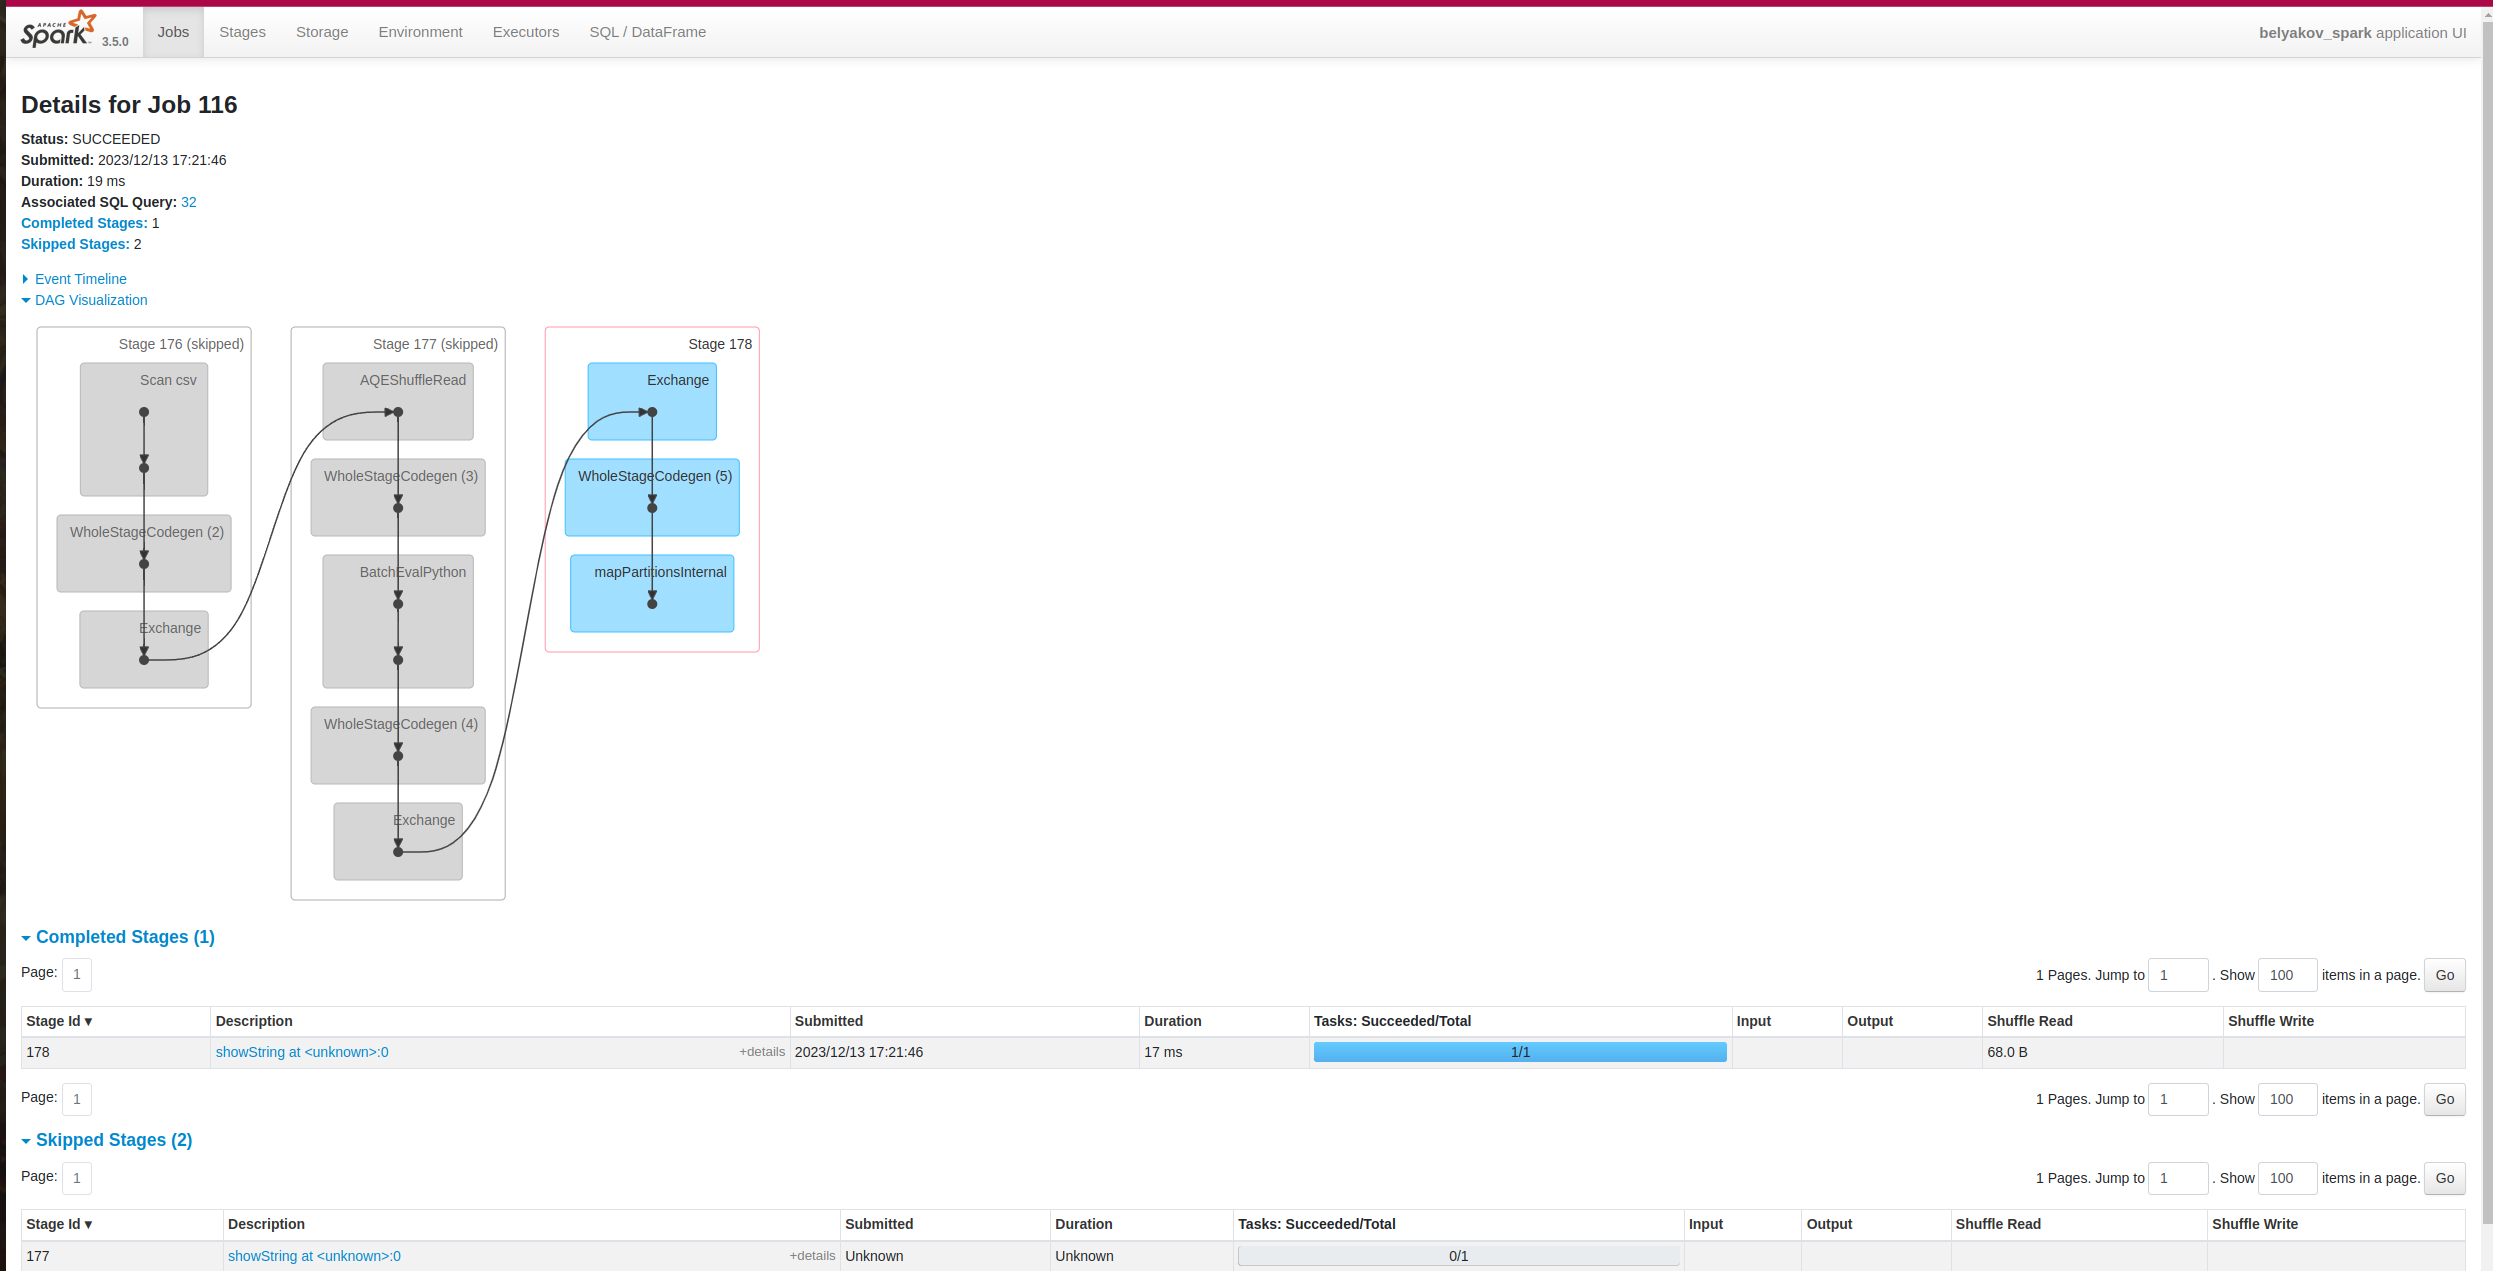


In [95]:
# 3 stages, 11 tasks